In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlrd
import csv

file_filter = 'KC19_d16t4_Safonov.xls'
file_ccd = 'ccd_prosilica2.crv'
file_star = 'a05.sp'

In [2]:
# Получение кривой пропускания фильтра

def filter_values(file):  
    def xls_to_csv(file):
        x =  xlrd.open_workbook(file)
        x1 = x.sheet_by_name('Измерение')
        csvfile = open('filter.csv', 'w')
        writecsv = csv.writer(csvfile, quoting=csv.QUOTE_ALL)

        for rownum in range(1, x1.nrows): # пропускаю первую сртоку в файле, тк. там текст
            writecsv.writerow(x1.row_values(rownum))

        csvfile.close()
        
    xls_to_csv(file)
    
    x_filter, y_filter = [], []
    with open('filter.csv') as f1:
        for line in f1:
            line = line.replace('"', '').strip().split(sep=',')
            if len(line) == 2:
                line = np.array(line, dtype=np.float32)
                x_filter.append(line[0])
                y_filter.append(line[1]/100)
    return x_filter, y_filter

In [3]:
# Кривая квантовой эффективности детектора

def ccd_values(file):
    with open(file) as f1, open(file) as f2:
        x_ccd = [int(np.array(line.strip().split(' '), float)[0]*1000) for line in f1]
        x_ccd = x_ccd[:len(x_ccd)-1] # последнее значение по длине волны почему-то 0, тут я его удаляю
    
        y_ccd = []
        for line in f2:
            if len(np.array(line.strip().split(' '), dtype=np.float32)) == 2:
                y_ccd.append(np.array(line.strip().split(' '), dtype=np.float32)[1])
                
    return x_ccd, y_ccd

In [4]:
# Излучение звезды

def star_values(file):
    with open(file) as f1, open(file) as f2:
        x_star, y_star = [], []
        for line in f1:
            line = line.strip().split(' ')
            del line[1]        
            x_star.append(int(np.array(line[0], float)))
            y_star.append(np.array(line[1], float))   
    return x_star, y_star

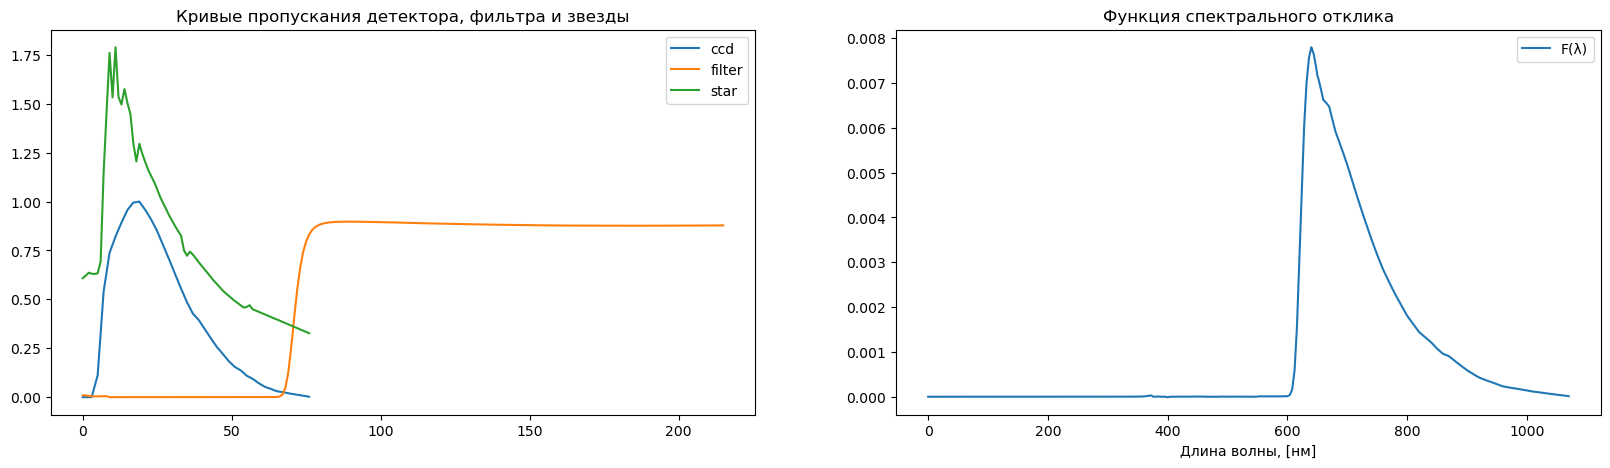

In [5]:
# Функция спектрального отклика

def processF_lamda(file_star=None, file_filter=None, file_ccd=None):
    x_filter, y_filter = filter_values(file_filter)
    x_ccd, y_ccd = ccd_values(file_ccd)
    x_star, y_star = star_values(file_star)

    x_max = int(np.min([x_ccd[-1], x_filter[-1], x_star[-1]]))
    x_min = np.max([x_ccd[0], x_filter[0], x_star[0]])

    lambdas = np.linspace(0, x_max, x_max+1, dtype=int)

    interp_ccd = np.interp(lambdas, x_ccd, y_ccd)
    interp_filter = np.interp(lambdas, x_filter, y_filter)
    interp_star = np.interp(lambdas, x_star, y_star)
    f_lambda = interp_ccd * interp_filter * interp_star
    f_lambda = f_lambda / np.sum(f_lambda) 

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    ax1.plot(y_ccd, label='ccd')
    ax1.plot(y_filter, label='filter')
    ax1.plot(y_star, label='star')
    ax1.legend()
    ax1.set_title('Кривые пропускания детектора, фильтра и звезды')

    ax2.plot(f_lambda, label='F(λ)')
    ax2.legend()
    ax2.set_title('Функция спектрального отклика')
    ax2.set_xlabel('Длина волны, [нм]')
    print()
    
    return f_lambda

f_lambda=processF_lamda(file_star=file_star, file_filter=file_filter, file_ccd=file_ccd)

C:\Users\miron\AppData\Local\Temp\ipykernel_2660\687917854.py:13: RuntimeWarning: invalid value encountered in divide
  res_fft = pow((np.imag(np.fft.fft(f_lambda_new/lambdas))), 2)


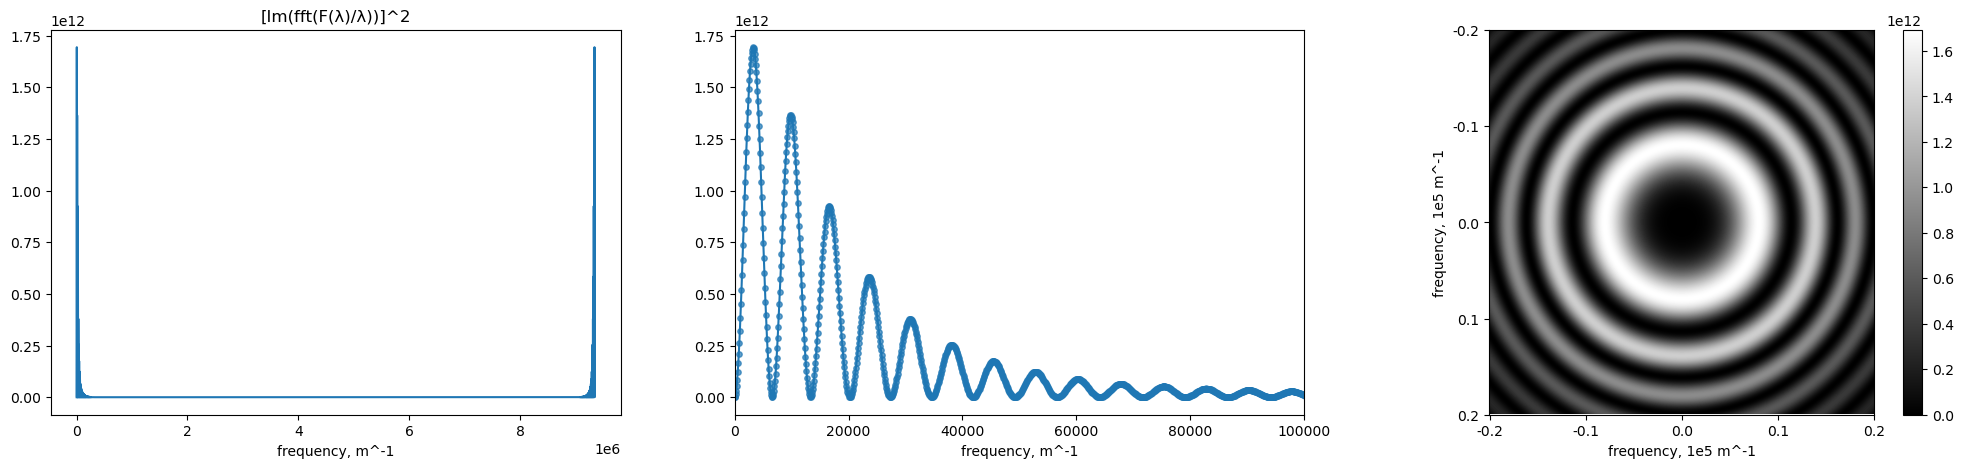

In [6]:
def processSpectralFilter(f_lambda=None, z=None, D=None, D_pix=None):
#     z - дистанция распространения, [м]
#     D - диаметр телескопа, [м]
#     D_pix - диаметр телескопа в пикселях, [n_pix]
    coeff=100
    k = 1000*coeff
    lambda_max = len(f_lambda) - 1
    lambda_max_new = int(lambda_max*coeff)
    lambdas = np.linspace(0, lambda_max_new, k) * pow(10, -9) # [м]

    tail = np.zeros((len(lambdas) - len(f_lambda)))
    f_lambda_new = np.append(f_lambda, tail)
    res_fft = pow((np.imag(np.fft.fft(f_lambda_new/lambdas))), 2)

    delta_lambdas = (lambda_max_new / len(lambdas)) * pow(10, -9) # период дискретизации, шаг по частоте [м]
    omega_lambdas_scale = 1 / (delta_lambdas) # максимальное значение по частоте, [м^-1]
    
    nx = 2*D_pix # размер окна, [n_pix]
    delta = D/D_pix # шаг субапертуры, период дискретизации (то, насколько одно значение отстает от следующего) [м]
    f_scale = 1/(delta*nx) # шаг по частоте, [м^-1]

    xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
    xx_scale = f_scale * xx 
    yy_scale = f_scale * yy
    f_abs = np.sqrt(pow(xx_scale, 2) + pow(yy_scale, 2))

    omega = 0.5 * z * pow(f_abs, 2) # аргумент, шаг по частоте, [м^-1]
    omega = np.ravel(omega)
    omega_new = np.interp(omega, np.linspace(0, omega_lambdas_scale, k), res_fft)
    omega_new = np.resize(omega_new, (nx, nx))



    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

    ax1.plot(np.linspace(0, omega_lambdas_scale/coeff, k), res_fft)
    ax1.set_title('[Im(fft(F(λ)/λ))]^2')
    ax1.set_xlabel('frequency, m^-1')

    ax2.scatter(np.linspace(0, omega_lambdas_scale/coeff, k), res_fft, alpha=0.7, s=15)
    ax2.plot(np.linspace(0, omega_lambdas_scale/coeff, k), res_fft)
    ax2.set_xlim(xmin = 0*pow(10,6), xmax = 0.1*pow(10, 6))
    ax2.set_xlabel('frequency, m^-1')

    fig.colorbar(ax3.imshow(omega_new, cmap='gray'), ax=ax3)
    ax3.grid(False)
    # x = np.round(pow(10, -9) * omega_lambdas_scale * np.linspace(-omega_new.shape[0]//2, omega_new.shape[0]//2, 5) / 228, 2)
    x = np.round(np.linspace(-0.2, 0.2, 5), 2)
    ax3.set_xticks(np.linspace(0, omega_new.shape[1], 5))
    ax3.set_yticks(np.linspace(0, omega_new.shape[0], 5))
    ax3.set_xticklabels(x)
    ax3.set_yticklabels(x)
    ax3.set_xlabel('frequency, 1e5 m^-1')
    ax3.set_ylabel('frequency, 1e5 m^-1')
    print()
    
    return omega_new

omega_new = processSpectralFilter(f_lambda=f_lambda, z=2000, D=2.5, D_pix=226)

In [ ]:
delta = (2.5)/(452) # 0.55 sm
        tmp2km = processGammaMono(1994, lambda_, cjk=cjk, const2=const2, nx=nx, fx=fx, fy=fy, Aff113=Aff113)
        tmp25km = processGammaMono(24985, lambda_, cjk=cjk, const2=const2, nx=nx, fx=fx, fy=fy, Aff113=Aff113)
        print('lambda:', lambda_)
        print('2km:', np.max(tmp2km)*1e-11, '1.67601e+11')
        print('25km:', np.max(tmp25km)*1e-11, '14.5482e+11')
        
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
        with open('wf_square_55_650_fromMatwey.dat') as f:
            y_values, x_values = [], []
            for line in f:
                line_z = float(line.strip().split(sep=',')[0])
                line_z = round(line_z, 4)
                line_z = int(line_z*1000)
                y_values.append(line_z)
                x_values.append(float(line.strip().split(sep=',')[1]))
        
        ves = []
        for z_value in y_values:
            ves.append(np.max(processGammaMono(z_value, lambda_, cjk=cjk, const2=const2, nx=nx, fx=fx, fy=fy, Aff113=Aff113)))
        
        plt.figure()
        plt.plot(x_values, y_values, label='Matwey')
        plt.plot(ves, y_values, label='My')
        plt.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
        plt.ylabel('z, m')
        plt.legend()    
        # !!!!!!!!!!!!!!!!!!!!!

In [ ]:
# fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(25, 5))

# ax1.plot(main_lambdas, main_result, c='black', label='F(λ)')
# ax1.set_xlabel('λ, м')
# ax1.legend()
# ax1.grid(color = 'black', linestyle='--', alpha = 0.2)

# fig.colorbar(ax3.imshow(omega_new, cmap='gray'), ax=ax3)
# ax3.grid(False)
# x = np.round(pow(10, -9) * omega_lambdas_scale/10 * np.linspace(-omega_new.shape[0]//2, omega_new.shape[0]//2, 5) / 256, 2)
# ax3.set_xticks(np.linspace(0, omega_new.shape[1], 5))
# ax3.set_yticks(np.linspace(0, omega_new.shape[0], 5))
# ax3.set_xticklabels(x)
# ax3.set_yticklabels(x)
# ax3.set_xlabel('frequency, 1e9 м^-1')
# ax3.set_ylabel('frequency, 1e9 м^-1')

# fig.savefig('C:/astro/response_func.png', bbox_inches='tight')
# print(' ')

In [2]:
def reference_filter(coeff, lambda_=None, sigma=None):
    k = 1000*coeff
    max_lambda_new = 1070*coeff
    lambdas = np.linspace(0, max_lambda_new, k) * pow(10, -9) # длина волны, [м]
    delta_lambdas = (max_lambda_new / len(lambdas)) * pow(10, -9) # период дискредизации, [м]
    omega_lambdas_scale = 1 / (delta_lambdas) # максимальное значение по частоте, [м^-1]
    
    a1 = (lambdas / lambda_) * (1 / (sigma * np.sqrt(2 * np.pi)))
    a2 = np.exp( - pow(lambdas - lambda_, 2) / (2 * pow(sigma, 2)))
    F = a1 * a2
    F = F/np.sum(F) # нормировка для Фурье-преобразования
    F_fft = np.fft.fft(F)
    F_fft2 = pow((np.imag(np.fft.fft(F/lambdas))), 2)
    
    frequencys = np.linspace(0, omega_lambdas_scale, k)
    return frequencys, F_fft2

frequencys, F_fft2 = reference_filter(coeff, lambda_=650*pow(10, -9), sigma=65 * pow(10, -9))

plt.figure()
plt.scatter(frequencys, F_fft2, alpha=0.5, s=5, color='gray', label='Reference')
plt.xlim(xmax = 0.1*pow(10, 8))
plt.xlim(xmin = 0*pow(10,8))
plt.legend()
plt.title('Аналитическая функция Tokovinin2003, eq. 18')
print()

NameError: name 'coeff' is not defined

In [3]:
lambda_ = 650*pow(10, -9) # длина волны, [м]


max_lambda = 100000 # максимальное значение длины волны, [нм]
k = 100000

lambdas = np.linspace(0, max_lambda, k) * pow(10, -9) # длина волны, [м]
delta_lambdas = (max_lambda / len(lambdas)) * pow(10, -9) # период дискредизации, [м]
omega_lambdas_scale = 1 / (delta_lambdas) # максимальное значение по частоте, [м^-1]

a1 = 1 / lambda_
a2 = np.sin(2 * np.pi * lambda_ * np.linspace(0, omega_lambdas_scale, k))
a3 = np.exp(-2 * pow(np.pi, 2) * pow(sigma, 2) * pow(np.linspace(0, omega_lambdas_scale, k), 2))
f = pow(a1 * a2 * a3, 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 5))

ax1.plot(np.linspace(0, omega_lambdas_scale, k), f)
ax1.set_title('eq. 19 - tokovinin2003', fontsize = 20)

ax2.plot(np.linspace(0, omega_lambdas_scale, k), f)
ax2.set_xlim(xmax = 0.1*pow(10, 8))
ax2.set_xlim(xmin = 0*pow(10,8))

NameError: name 'sigma' is not defined

Text(0.5, 1.0, 'eq. 20 - tokovinin2003')

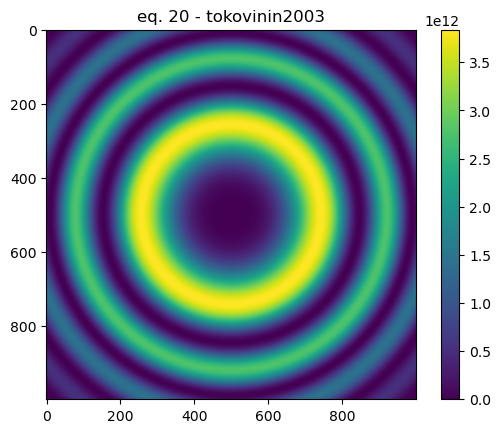

In [4]:
nx = 1000 # размер окна, [n_pix]
D = 2.5 # диаметр телескопа, [м]
D_pix = 228 # диаметр телескопа в пикселях, [n_pix]
lambda_ = 500*pow(10, -9) # длина волны, [м]
delta = D/D_pix # шаг субапертуры, период дискретизации (то, насколько одно значение отстает от следующего) [м]
z = 2000 # дистанция распространения, [м]
f_scale = 1/(delta*nx) # шаг по частоте, [м^-1]

xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
fx = f_scale * xx 
fy = f_scale * yy
f_abs = fx**2 + fy**2

sigma = 65 * pow(10, -9) # FWHM = 2*sqrt(2*Ln(2))*sigma, [м]
a1 = np.exp(- pow(np.pi, 2) * pow(z, 2) * pow(f_abs, 2) * pow(sigma, 2))
a2 = pow(np.sin(np.pi*z*lambda_*(f_abs)), 2)
a3 = pow(lambda_, -2)
S = a1 * a2 * a3 

plt.figure()
plt.imshow(S)
plt.colorbar()
plt.grid(False)
plt.title('eq. 20 - tokovinin2003')